# Time Series With PlanetScope for Agriculture

<b>Who: </b> You are a Remote Sensing Scientist or GIS Data Engineer at an agriculture company. 

<b>What: </b> You are trying to understand field level crop performance for yield estimation or for modelling agriculture inputs for a specific region or crop.

<b>How:</b> You've already created a PlanetScope Subscription over a 100,000 hectare AOI in Iowa and delivered all the data to your Sentinel Hub account.

## Step 1️⃣ - Set up the environment

### Import Statements

In [278]:
from ipyleaflet import Map, GeoData, basemaps, LayersControl
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import getpass
import json

# Sentinel Hub Python Library
from sentinelhub import (
    CRS,
    DataCollection,
    Geometry,
    SentinelHubStatistical,
    SentinelHubStatisticalDownloadClient,
    SHConfig,
    parse_time
)


# Planet Visualization Library
from planet_style import set_theme
set_theme()

print("Packages Imported")

Packages Imported


In [ ]:
from sentinelhub import parse_time
import pandas as pd
import numpy as np

def stats2df(stats_data):
    """Transform Statistical API response into a pandas.DataFrame"""
    df_data = []

    for single_data in stats_data["data"]:
        df_entry = {}
        is_valid_entry = True
        df_entry["interval_from"] = parse_time(single_data["interval"]["from"]).date()
        df_entry["interval_to"] = parse_time(single_data["interval"]["to"]).date()

        for output_name, output_data in single_data["outputs"].items():
            for band_name, band_values in output_data["bands"].items():
                band_stats = band_values["stats"]
                if band_stats["sampleCount"] == band_stats["noDataCount"]:
                    is_valid_entry = False
                    break

                for stat_name, value in band_stats.items():
                    col_name = f"{output_name}_{band_name}_{stat_name}"
                    if stat_name == "percentiles":
                        for perc, perc_val in value.items():
                            perc_col_name = f"{col_name}_{perc}"
                            df_entry[perc_col_name] = perc_val
                    else:
                        df_entry[col_name] = value

        if is_valid_entry:
            df_data.append(df_entry)

    return pd.DataFrame(df_data)


#calculates the moving average given a time series, x, and a window size, w.

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

### Connect to Sentinel Hub

In [279]:
# To use this, you must create a Sentinel Hub account: sentinel-hub.com/pricing

# and set configure the Sentinel Hub Python package: https://sentinelhub-py.readthedocs.io/en/latest/configure.html


config = SHConfig()

if not config.sh_client_id or not config.sh_client_secret:
    print("No credentials found, please provide the OAuth client ID and secret.")
else:
    print("Connected to Sentinel Hub")

Connected to Sentinel Hub


***
## Step 2️⃣ - Load your data

We need two things to get started:

1. Our PlanetScope data in Sentinel Hub 📊
2. Agriculture Field Boundaries 🚜

### Load PlanetScope data from Sentinel Hub

In [280]:
# you must create a PlanetScope subscription in Sentinel Hub and retrieve the Collect ID, find more at the link below:
# https://docs.sentinel-hub.com/api/latest/data/planet/planet-scope/

collection_id = getpass.getpass("Enter Collection ID: ")

PlanetScope_data_collection = DataCollection.define_byoc(PlanetScope_collection_id)

print("\nUsing Sentinel Hub Collection '{}'".format(collection_id[0:14] + "..."))

Enter Collection ID:  ········



Using Sentinel Hub Collection '9a0111ae-9283-...'


### Load in agriculture field boundaries

In [281]:
# create a geojson file with agriculture fields over an AOI that corresponds with your PlanetScope collection

agriculture_fields = gpd.read_file("agriculture_fields.geojson")
agriculture_fields_3857 = agriculture_fields.to_crs(3857)

center = (43.135, -95.65)

m = Map(center=center, zoom = 12, basemap= basemaps.Esri.WorldImagery)

geo_data = GeoData(geo_dataframe = agriculture_fields,
                   style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name = 'Agriculture Fields')

m.add_layer(geo_data)
m.add_control(LayersControl())

print("{} Farm boundaries imported!".format(len(agriculture_fields)))

display(m)

36 Farm boundaries imported!


Map(center=[43.135, -95.65], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

***
## Step 3️⃣ - Analyze PlanetScope!

<b>Question: </b> In the 2022 season, how did NDVI values change over time within each field?

To answer this, we can use the Sentinel Hub <b>Statistical API!</b>

In [282]:
# Pick what data to analyze
input_data = SentinelHubStatistical.input_data(PlanetScope_data_collection)

# Choose the  time of interest (TOI)
yearly_time_interval = "2022-04-1", "2022-11-29"

# Specify a resolution
resx = 3
resy = 3

# Determine what indices to calculate (e.g. NDVI with cloud coverage statistics)
ndvi_evalscript = """
//VERSION=3

function setup() {
  return {
    input: [
      {
        bands: [
          "Red",
          "NIR",
          "dataMask",
          "UDM2_Clear"
        ]
      }
    ],
    output: [
      {
        id: "ndvi",
        bands: 2
      },
      {
        id: "dataMask",
        bands: 1
      }
    ]
  }
}


function isClear (udm2_clear) {
  if (udm2_clear == 0)  {
    return false;
  }
  else {
    return true;
  }
}

function evaluatePixel(samples) {
  
    let ndvi = (samples.NIR-samples.Red)/(samples.NIR+samples.Red);

    const indexVal = samples.dataMask === 1 ? ndvi : NaN;

    const clear = isClear(samples.UDM2_Clear)?0:1

    let id_default = colorBlend(ndvi,  [0.0, 0.5, 1.0],
      [
        [1,0,0, samples.dataMask * samples.UDM2_Clear], 
        [1,1,0,samples.dataMask * samples.UDM2_Clear], 
        [0.1,0.31,0,samples.dataMask * samples.UDM2_Clear], 
      ])

      return {
        ndvi: [ndvi, clear],
        dataMask: [samples.dataMask],
      };
}
"""

aggregation = SentinelHubStatistical.aggregation(
    evalscript=ndvi_evalscript, time_interval=yearly_time_interval, aggregation_interval="P1D", resolution=(resx, resy)
)

histogram_calculations = {"ndvi": {"histograms": {"default": {"nBins": 20, "lowEdge": -1.0, "highEdge": 1.0}}}}


print("Request formatted: \n\n----\n\n" + json.dumps(aggregation, sort_keys=True, indent=4).replace('\\n','\n'))

Request formatted: 

----

{
    "aggregationInterval": {
        "of": "P1D"
    },
    "evalscript": "
//VERSION=3

function setup() {
  return {
    input: [
      {
        bands: [
          \"Red\",
          \"NIR\",
          \"dataMask\",
          \"UDM2_Clear\"
        ]
      }
    ],
    output: [
      {
        id: \"ndvi\",
        bands: 2
      },
      {
        id: \"dataMask\",
        bands: 1
      }
    ]
  }
}


function isClear (udm2_clear) {
  if (udm2_clear == 0)  {
    return false;
  }
  else {
    return true;
  }
}

function evaluatePixel(samples) {
  
    let ndvi = (samples.NIR-samples.Red)/(samples.NIR+samples.Red);

    const indexVal = samples.dataMask === 1 ? ndvi : NaN;

    const clear = isClear(samples.UDM2_Clear)?0:1

    let id_default = colorBlend(ndvi,  [0.0, 0.5, 1.0],
      [
        [1,0,0, samples.dataMask * samples.UDM2_Clear], 
        [1,1,0,samples.dataMask * samples.UDM2_Clear], 
        [0.1,0.31,0,samples.dataMask * samples.UDM2_C

In [283]:
# For each polygon field boundary, create a Statistical API request

ndvi_requests = []

for geo_shape in agriculture_fields_3857.geometry.values:
    request = SentinelHubStatistical(
        aggregation=aggregation,
        input_data=[input_data],
        geometry=Geometry(geo_shape, crs=CRS(agriculture_fields_3857.crs)),
        calculations=histogram_calculations,
        config=config,
    )
    ndvi_requests.append(request)
    
print("{} Statistical API requests prepared!".format(len(ndvi_requests)))

36 Statistical API requests prepared!


In [71]:
%%time

## post the requests

download_requests = [ndvi_request.download_list[0] for ndvi_request in ndvi_requests]

client = SentinelHubStatisticalDownloadClient(config=config)

ndvi_stats = client.download(download_requests)

print("{} Results from the Statistical API!".format(len(ndvi_requests)))

36 Results from the Statistical API!
CPU times: total: 2.09 s
Wall time: 1min 46s


***
## Step 4️⃣ - Visualize our data!

In [284]:

ndvi_dfs = [stats2df(polygon_stats) for polygon_stats in ndvi_stats]

for df, oid in zip(ndvi_dfs, agriculture_fields["OBJECTID"].values):
    df["OBJECTID"] = oid

ndvi_df = pd.concat(ndvi_dfs)

#calculate date as day of the year for time integration
ndvi_df["day_of_year"] = ndvi_df.apply(lambda row: row.interval_from.timetuple().tm_yday, axis=1)

del_cols = [i for i in list(ndvi_df) if i not in ["interval_from", "ndvi_B0_mean", "ndvi_B1_mean", "day_of_year", "OBJECTID"]]

ndvi_df = ndvi_df.drop(columns=del_cols).rename(columns={'interval_from': 'date', 'ndvi_B0_mean': 'ndvi_mean', 'ndvi_B1_mean': 'clouds', 'OBJECTID':'field_id'})

ndvi_df

,date,ndvi_mean,clouds,field_id,day_of_year
0,2022-04-01,0.177674,0.0,1,91
1,2022-04-02,0.209723,0.0,1,92
2,2022-04-04,0.218447,0.0,1,94
3,2022-04-09,0.207054,0.0,1,99
4,2022-04-10,0.137826,1.0,1,100
...,...,...,...,...,...
148,2022-11-22,0.165217,0.0,41,326
149,2022-11-23,0.188155,0.0,41,327
150,2022-11-24,0.181901,0.0,41,328
151,2022-11-25,0.196477,0.0,41,329


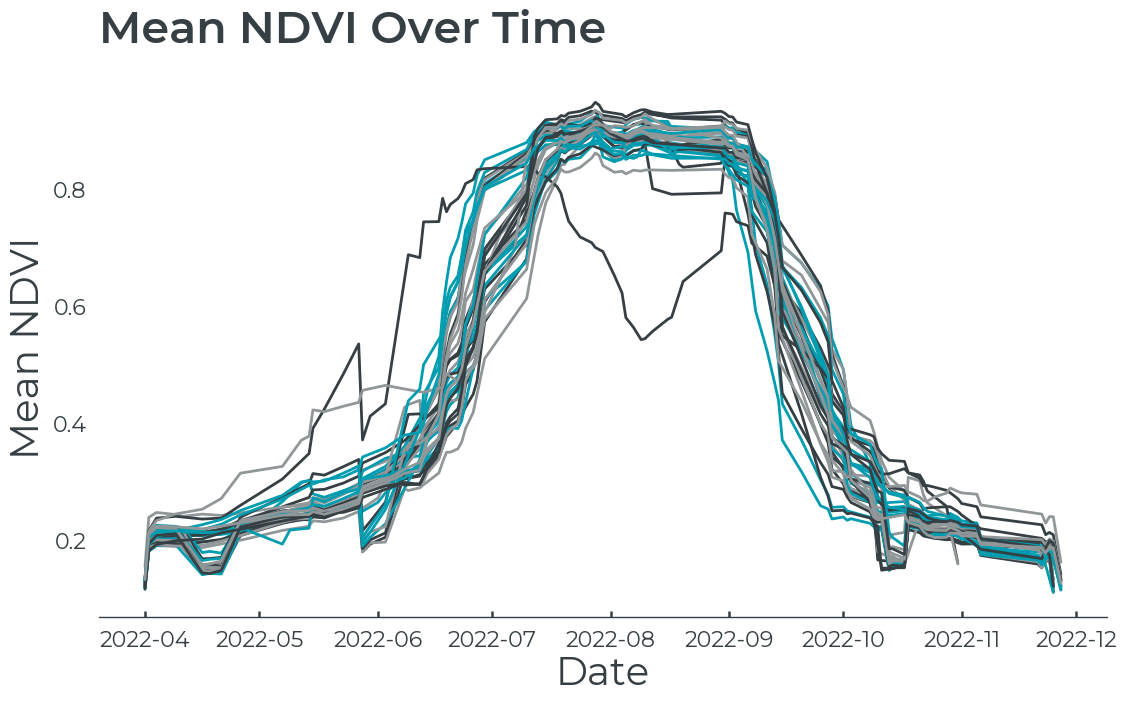

In [285]:
pd.options.mode.chained_assignment = None 

fig, ax = plt.subplots(figsize=(13, 7))

for idx, field_id in enumerate(agriculture_fields["OBJECTID"].values):

    series = ndvi_df[(ndvi_df["field_id"] == field_id) & (ndvi_df["clouds"] == 0)]
            
    #series.plot(ax=ax, x="interval_from", y="ndvi_B0_mean", color=f"C{idx}", label=("Field " + str(field_id)))
    
    #rolling average option
    rolling_avg = moving_average(series["ndvi_mean"],3)
    series["rolling_avg"] = rolling_avg
    series.plot(ax=ax, x="date", y="rolling_avg", color=f"C{idx}", legend=False)


    
title = ax.set_title('Mean NDVI Over Time', fontsize=32)
ylabel = ax.set_ylabel("Mean NDVI", fontsize=28)
xlabel = ax.set_xlabel("Date", fontsize=28)


***
## Step 5️⃣ - More Analysis!



### 1) Area under the curve



![Area Under Curve](https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/thumbnails/image/LB_TIN_0.gif)

(source: USGS)

In [286]:
aucs = []

for i in ndvi_df.field_id.unique():
    
    series = ndvi_df[(ndvi_df["field_id"] == i) & (ndvi_df["clouds"] == 0)]
    
    auc = np.trapz(series["ndvi_mean"], dx=np.diff(series['day_of_year']))
    
    aucs.append([str(i), auc])
    
    
aucs = pd.DataFrame(aucs, columns=("Field ID", "Area Under Curve"))

min_auc = aucs.min()
max_auc = aucs.max()

min_max_field_ids = [aucs.loc[aucs["Area Under Curve"].idxmin()][0], aucs.loc[aucs["Area Under Curve"].idxmax()][0]]

print("Field {} has the LOWEST area under the curve at {}.". format(aucs.loc[aucs["Area Under Curve"].idxmin()][0], aucs.loc[aucs["Area Under Curve"].idxmin()][1].round(2)))
print("---\nField {} has the HIGHEST area under the curve at {}\n---".format(aucs.loc[aucs["Area Under Curve"].idxmax()][0], aucs.loc[aucs["Area Under Curve"].idxmax()][1].round(2)))

Field 14 has the LOWEST area under the curve at 102.3.
---
Field 1 has the HIGHEST area under the curve at 121.61
---


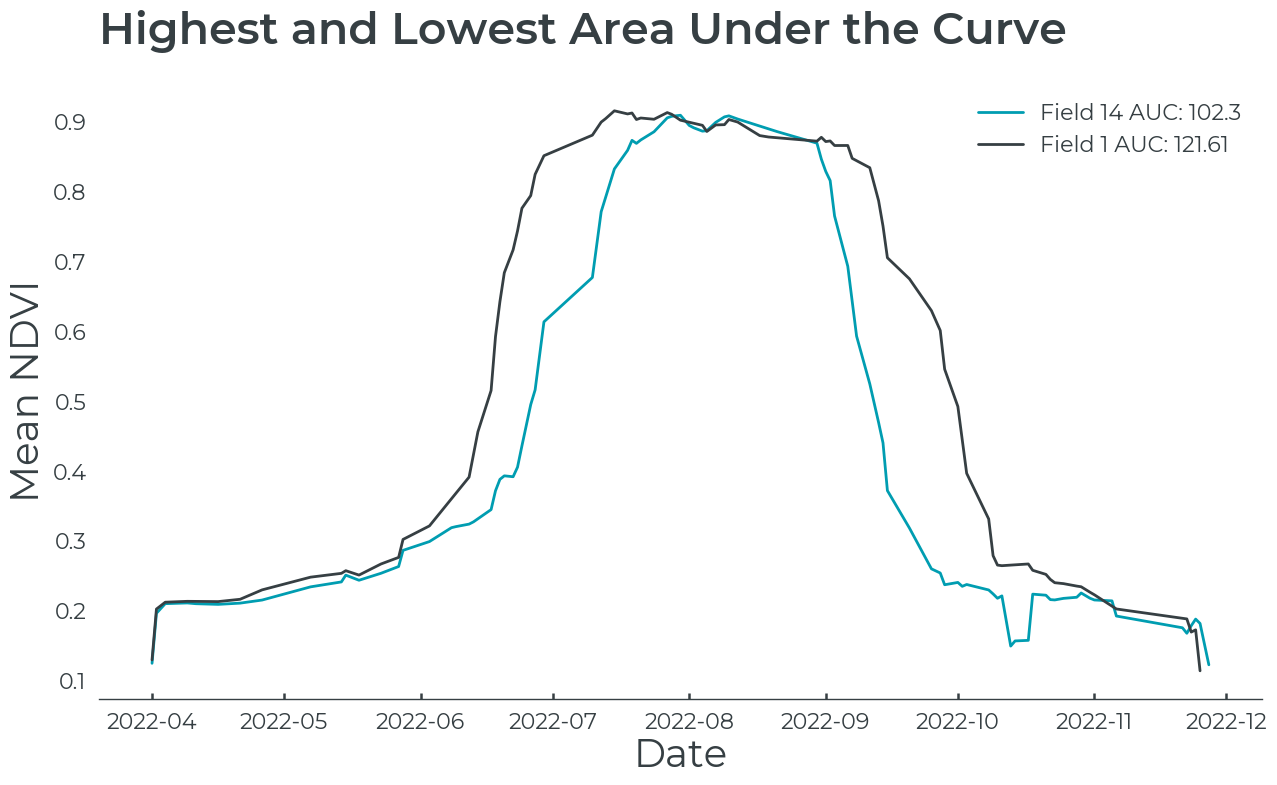

In [287]:
pd.options.mode.chained_assignment = None 

fig, ax = plt.subplots(figsize=(15, 8))

for i in min_max_field_ids:

    series = ndvi_df[(ndvi_df["field_id"] == int(i)) & (ndvi_df["clouds"] == 0)]
    
    auc = np.trapz(series["ndvi_mean"], dx=np.diff(series['day_of_year']))
        
    #series.plot(ax=ax, x="interval_from", y="ndvi_B0_mean", color=f"C{idx}", label=("Field " + str(field_id)))
    
    #rolling average option
    rolling_avg = moving_average(series["ndvi_mean"],3)
    series["rolling_avg"] = rolling_avg
    series.plot(ax=ax, x="date", y="rolling_avg", legend=True, label=("Field " + str(i) + " AUC: " + str(round(auc,2))))


    
title = ax.set_title('Highest and Lowest Area Under the Curve', fontsize=32)
ylabel = ax.set_ylabel("Mean NDVI", fontsize=28)
xlabel = ax.set_xlabel("Date", fontsize=28)

***
### 2) Multiple indices over a single field

Different spectral indices might be more useful during different parts of the growing season.  Customers can dynamically request multiple indices at the same time.

Field ID: 1
POLYGON ((-95.64399195350381 43.14985585045176, -95.63409853598858 43.14986758702416, -95.63413071004882 43.15695598897449, -95.64397586647371 43.15707333965183, -95.64399195350381 43.14985585045176))


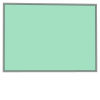

In [288]:
polygons_gdf = gpd.read_file("agriculture_fields.geojson")
polygons_gdf_3857 = polygons_gdf.to_crs(3857)

print("Field ID: " + str(polygons_gdf["OBJECTID"].iloc[0]))
print(str(polygons_gdf["geometry"].iloc[0]))
polygons_gdf["geometry"].iloc[0]

In [289]:
# Pick what data to analyze
input_data = SentinelHubStatistical.input_data(PlanetScope_data_collection)

# Choose the  time of interest (TOI)
yearly_time_interval = "2022-04-1", "2022-11-29"

# Specify a resolution
resx = 3
resy = 3

multi_indices_evalscript = """
//VERSION=3

function setup() {
  return {
    input: [
      {
        bands: [
          "Red",
          "NIR",
          "dataMask",
          "UDM2_Clear",
          "RedEdge",
          "Green"
        ]
      }
    ],
    output: [
      {
        id: "ndvi",
        bands: 2
      },
      {
        id: "msavi",
        bands: 2
      },
      {
        id: "ndre",
        bands: 2
      },
      {
        id: "rtvicore",
        bands: 2
      },
      {
        id: "dataMask",
        bands: 1
      }
    ]
  }
}


function isClear (udm2_clear) {
  if (udm2_clear == 0)  {
    return false;
  }
  else {
    return true;
  }
}

function evaluatePixel(samples) {
  
    let ndvi = (samples.NIR-samples.Red)/(samples.NIR+samples.Red);
    
    let msavi = 0.5 * (2.0 * samples.NIR + 1 - (((2 * samples.NIR + 1)**2) -8 * (samples.NIR-samples.Red))**0.5)
    
    let rtvicore = (100 * (samples.NIR - samples.RedEdge) - 10 * (samples.NIR - samples.Green))
    
    let ndre = (samples.NIR - samples.RedEdge)/(samples.NIR + samples.RedEdge)

    const indexVal = samples.dataMask === 1 ? ndvi : NaN;

    const clear = isClear(samples.UDM2_Clear)?0:1

    let id_default = colorBlend(ndvi,  [0.0, 0.5, 1.0],
      [
        [1,0,0, samples.dataMask * samples.UDM2_Clear], 
        [1,1,0,samples.dataMask * samples.UDM2_Clear], 
        [0.1,0.31,0,samples.dataMask * samples.UDM2_Clear], 
      ])

      return {
        ndvi: [ndvi, clear],
        msavi: [msavi, clear],
        rtvicore: [rtvicore, clear],
        ndre: [ndre, clear],
        dataMask: [samples.dataMask],
      };
}
"""

aggregation = SentinelHubStatistical.aggregation(
    evalscript=multi_indices_evalscript, time_interval=yearly_time_interval, aggregation_interval="P1D", resolution=(resx, resy)
)

histogram_calculations = {"ndvi": {"histograms": {"default": {"nBins": 20, "lowEdge": -1.0, "highEdge": 1.0}}}}

request = SentinelHubStatistical(
    aggregation=aggregation,
    input_data=[input_data],
    geometry=Geometry(agriculture_fields_3857.head(1).geometry.values[0], crs = CRS(agriculture_fields_3857.head(1).crs)),
    calculations=histogram_calculations,
    config=config,
)

print("Request formatted: \n\n----\n\n" + json.dumps(aggregation, sort_keys=True, indent=4).replace('\\n','\n'))

Request formatted: 

----

{
    "aggregationInterval": {
        "of": "P1D"
    },
    "evalscript": "
//VERSION=3

function setup() {
  return {
    input: [
      {
        bands: [
          \"Red\",
          \"NIR\",
          \"dataMask\",
          \"UDM2_Clear\",
          \"RedEdge\",
          \"Green\"
        ]
      }
    ],
    output: [
      {
        id: \"ndvi\",
        bands: 2
      },
      {
        id: \"msavi\",
        bands: 2
      },
      {
        id: \"ndre\",
        bands: 2
      },
      {
        id: \"rtvicore\",
        bands: 2
      },
      {
        id: \"dataMask\",
        bands: 1
      }
    ]
  }
}


function isClear (udm2_clear) {
  if (udm2_clear == 0)  {
    return false;
  }
  else {
    return true;
  }
}

function evaluatePixel(samples) {
  
    let ndvi = (samples.NIR-samples.Red)/(samples.NIR+samples.Red);
    
    let msavi = 0.5 * (2.0 * samples.NIR + 1 - (((2 * samples.NIR + 1)**2) -8 * (samples.NIR-samples.Red))**0.5)
    
 

In [292]:
%%time

client = SentinelHubStatisticalDownloadClient(config=config)

spectral_indices = request.get_data()

CPU times: total: 62.5 ms
Wall time: 25.7 s


In [294]:
spectral_df = stats2df(spectral_indices[0])

spectral_df["scaled_rtvi"] = (spectral_df["rtvicore_B0_mean"] - spectral_df["rtvicore_B0_mean"] .min())/(spectral_df["rtvicore_B0_mean"] .max() - spectral_df["rtvicore_B0_mean"] .min())

del_cols = [i for i in list(spectral_df) if i not in ["interval_from", "ndvi_B0_mean", "ndvi_B1_mean", "scaled_rtvi", "ndre_B0_mean", "msavi_B0_mean"]]

spectral_df = spectral_df.drop(columns=del_cols).rename(columns={'interval_from': 'date', 'ndvi_B0_mean': 'ndvi_mean', 'ndre_B0_mean': 'ndre_mean', 'msavi_B0_mean': 'msavi_mean', 'ndvi_B1_mean': 'clouds', 'OBJECTID':'field_id'})

spectral_df

,date,ndvi_mean,clouds,ndre_mean,msavi_mean,scaled_rtvi
0,2022-04-01,0.177674,0.000000,0.135293,0.301282,0.099055
1,2022-04-02,0.209723,0.000000,0.152661,0.346360,0.117459
2,2022-04-04,0.218447,0.000000,0.158453,0.358227,0.130508
3,2022-04-09,0.207054,0.000000,0.154928,0.342721,0.142101
4,2022-04-10,0.137826,1.000000,0.094620,0.240067,0.148174
...,...,...,...,...,...,...
147,2022-11-22,0.166424,0.000000,0.122572,0.284805,0.170382
148,2022-11-23,0.175842,0.000000,0.122616,0.298602,0.168456
149,2022-11-24,0.164743,0.000000,0.112928,0.282490,0.155158
150,2022-11-25,0.175903,0.000000,0.128247,0.298677,0.179103


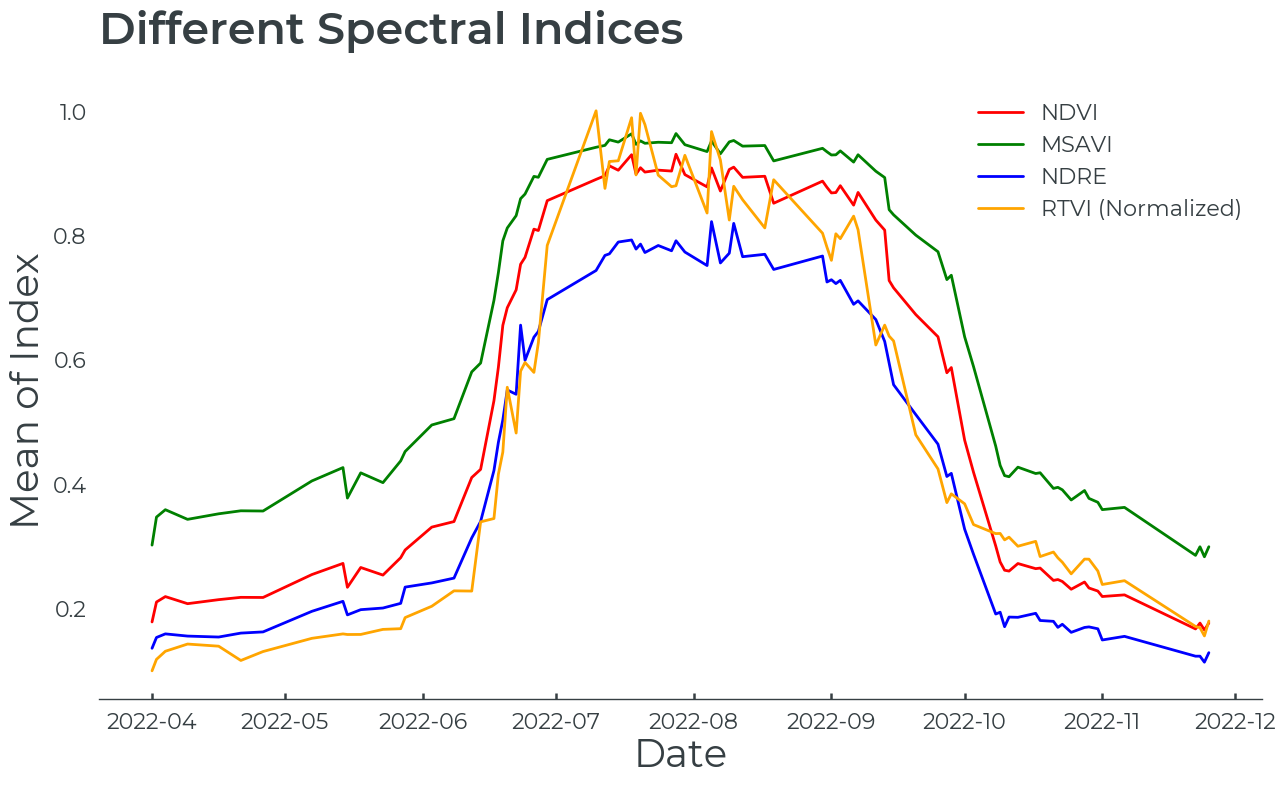

In [295]:
pd.options.mode.chained_assignment = None 

fig, ax = plt.subplots(figsize=(15, 8))


series = spectral_df[(spectral_df["clouds"] == 0)]

series.plot(ax=ax, x="date", y="ndvi_mean", color=f"red", label=("NDVI"))
series.plot(ax=ax, x="date", y="msavi_mean", color=f"green", label=("MSAVI"))
series.plot(ax=ax, x="date", y="ndre_mean", color=f"blue", label=("NDRE"))
series.plot(ax=ax, x="date", y="scaled_rtvi", color=f"orange", label=("RTVI (Normalized)"))

    
title = ax.set_title('Different Spectral Indices', fontsize=32)
ylabel = ax.set_ylabel("Mean of Index", fontsize=28)
xlabel = ax.set_xlabel("Date", fontsize=28)

---
### 3) Annual time series comparisons for a single field

In [ ]:
# Pick what data to analyze
input_data = SentinelHubStatistical.input_data(PlanetScope_data_collection)

# Choose the  time of interest (TOI)
yearly_time_interval = "2021-01-1", "2023-7-26"

# Specify a resolution
resx = 3
resy = 3

multi_indices_evalscript = """
//VERSION=3

function setup() {
  return {
    input: [
      {
        bands: [
          "Red",
          "NIR",
          "dataMask",
          "UDM2_Clear",
          "RedEdge",
          "Green"
        ]
      }
    ],
    output: [
      {
        id: "ndvi",
        bands: 2
      },
      {
        id: "msavi",
        bands: 2
      },
      {
        id: "ndre",
        bands: 2
      },
      {
        id: "rtvicore",
        bands: 2
      },
      {
        id: "dataMask",
        bands: 1
      }
    ]
  }
}


function isClear (udm2_clear) {
  if (udm2_clear == 0)  {
    return false;
  }
  else {
    return true;
  }
}

function evaluatePixel(samples) {
  
    let ndvi = (samples.NIR-samples.Red)/(samples.NIR+samples.Red);
    
    let msavi = 0.5 * (2.0 * samples.NIR + 1 - (((2 * samples.NIR + 1)**2) -8 * (samples.NIR-samples.Red))**0.5)
    
    let rtvicore = (100 * (samples.NIR - samples.RedEdge) - 10 * (samples.NIR - samples.Green))
    
    let ndre = (samples.NIR - samples.RedEdge)/(samples.NIR + samples.RedEdge)

    const indexVal = samples.dataMask === 1 ? ndvi : NaN;

    const clear = isClear(samples.UDM2_Clear)?0:1

    let id_default = colorBlend(ndvi,  [0.0, 0.5, 1.0],
      [
        [1,0,0, samples.dataMask * samples.UDM2_Clear], 
        [1,1,0,samples.dataMask * samples.UDM2_Clear], 
        [0.1,0.31,0,samples.dataMask * samples.UDM2_Clear], 
      ])

      return {
        ndvi: [ndvi, clear],
        msavi: [msavi, clear],
        rtvicore: [rtvicore, clear],
        ndre: [ndre, clear],
        dataMask: [samples.dataMask],
      };
}
"""

aggregation = SentinelHubStatistical.aggregation(
    evalscript=multi_indices_evalscript, time_interval=yearly_time_interval, aggregation_interval="P1D", resolution=(resx, resy)
)

histogram_calculations = {"ndvi": {"histograms": {"default": {"nBins": 20, "lowEdge": -1.0, "highEdge": 1.0}}}}

request = SentinelHubStatistical(
    aggregation=aggregation,
    input_data=[input_data],
    geometry=Geometry(agriculture_fields_3857.head(1).geometry.values[0], crs = CRS(agriculture_fields_3857.head(1).crs)),
    calculations=histogram_calculations,
    config=config,
)

print("Request formatted: \n\n----\n\n" + json.dumps(aggregation, sort_keys=True, indent=4).replace('\\n','\n'))

In [273]:
%%time

client = SentinelHubStatisticalDownloadClient(config=config)

spectral_indices = request.get_data()

CPU times: total: 109 ms
Wall time: 28 s


In [ ]:
spectral_df_3y = stats2df(spectral_indices[0])

spectral_df_3y["scaled_rtvi"] = (spectral_df_3y["rtvicore_B0_mean"] - spectral_df_3y["rtvicore_B0_mean"] .min())/(spectral_df_3y["rtvicore_B0_mean"].max() - spectral_df_3y["rtvicore_B0_mean"].min())

del_cols = [i for i in list(spectral_df_3y) if i not in ["interval_from", "ndvi_B0_mean", "ndvi_B1_mean", "scaled_rtvi", "ndre_B0_mean", "msavi_B0_mean"]]

spectral_df_3y = spectral_df_3y.drop(columns=del_cols).rename(columns={'interval_from': 'date', 'ndvi_B0_mean': 'ndvi_mean', 'ndre_B0_mean': 'ndre_mean', 'msavi_B0_mean': 'msavi_mean', 'ndvi_B1_mean': 'clouds', 'OBJECTID':'field_id'})

spectral_df_3y["day_of_year"] = spectral_df_3y.apply(lambda row: row.date.timetuple().tm_yday, axis=1)

spectral_df_3y["year"] = spectral_df_3y.apply(lambda row: row.date.year, axis=1)

spectral_df_3y

(120.0, 300.0)

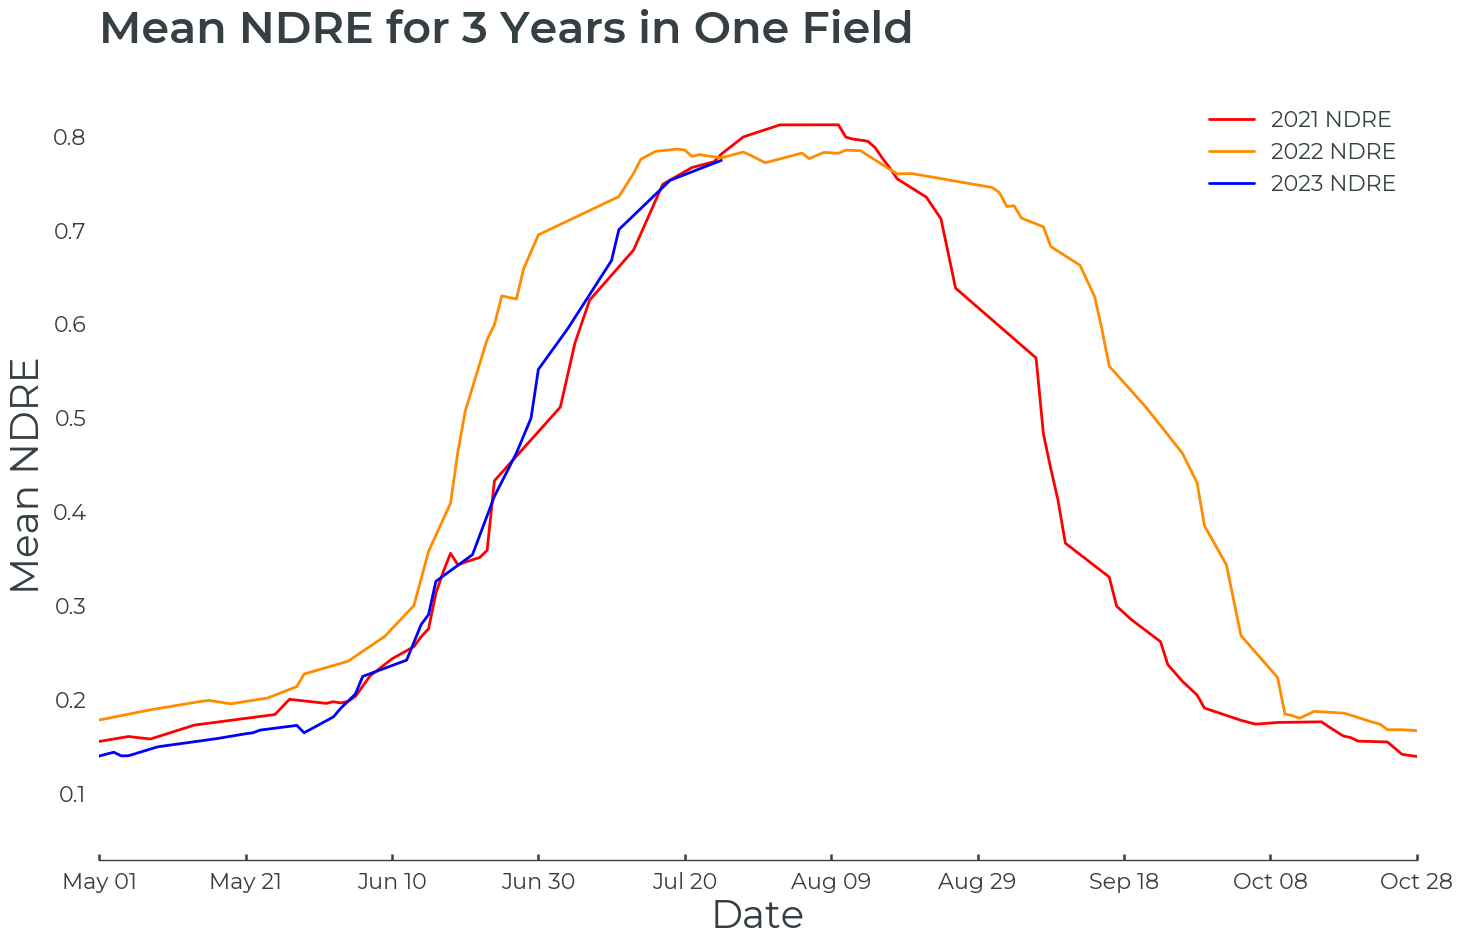

In [299]:
import matplotlib.dates as md

fig, ax = plt.subplots(figsize=(17, 10))

colors = ["red", "darkorange", "blue"]

i=0

for year in spectral_df_3y["year"].unique():
    
    series = spectral_df_3y[(spectral_df_3y["year"] == year) & (spectral_df_3y["clouds"] == 0)]
    
    #rolling average option
    rolling_avg = moving_average(series["ndre_mean"],3)
    series["rolling_avg"] = rolling_avg
    series[:-1].plot(ax=ax, x="day_of_year", y="rolling_avg", color=colors[i], label=(str(year) + " NDRE"))

    #series[:-1].plot(ax=ax, x="day_of_year", y="ndre_mean", color=colors[i], label=(str(year) + " NDRE"))
    i += 1

    
title = ax.set_title('Mean NDRE for 3 Years in One Field', fontsize=32)
ylabel = ax.set_ylabel("Mean NDRE", fontsize=28)
xlabel = ax.set_xlabel("Date", fontsize=28)

ax.xaxis.set_major_formatter(md.DateFormatter('%b %d'))
ax.set_xlim([120,300])


### Takeaways

1. Sentinel Hub is a powerful API for developers with an SDK to get started fast
2. Enables cloud-based raster and statistical analysis for scalable workflows, even without needing to downloading imagery
3. Extensible to support on-the-fly workflows with any customizable spectral index

What does this mean for customers? Planet can offer ways to <b> get insights faster, easier, and more dynamically</b> than ever before!